# FINAL 2CSSID Project - CNNs for images classification 

In [1]:
import os
import re
import math
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder

In [3]:
import matplotlib.pyplot as plt 
import matplotlib.image  as mpimg
from   matplotlib        import colors

%matplotlib inline

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, UpSampling2D
from tensorflow.keras.models import Sequential, Model

tf.__version__

2025-02-20 23:23:23.170371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740090203.199183   29284 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740090203.207047   29284 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 23:23:23.234328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.18.0'

## 1. Pre-processing

### 1.1. Useful functions

In [5]:
# When reading the PNG image with 3 channels,
# transparent parts are transformed into black
# However, normally they must be white
# So I assumed that the transparent part is encoded as (0, 0, 0, 0)
# In this case, I transform it to (255, 255, 255)
def rgba_to_rgb(img):
    if img.shape[2] != 4:
        return img

    # Create an output image with white background
    rgb_img = img[:, :, :3].copy()
    alpha_mask = img[:, :, 3] == 0  # Mask for transparent pixels

    # Set transparent pixels to white
    rgb_img[alpha_mask] = [255, 255, 255]

    return rgb_img

rgba_to_rgb(np.array([
    [[255, 200, 100, 255], [255, 200, 100, 255], [255, 200, 100, 0]],
    [[255, 200, 100, 255], [0, 0, 0, 0], [255, 200, 100, 200]]
]))

array([[[255, 200, 100],
        [255, 200, 100],
        [255, 255, 255]],

       [[255, 200, 100],
        [255, 255, 255],
        [255, 200, 100]]])

In [6]:
def show_images(imgs, y, n):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(imgs[i]) # recontruct the matrix
        plt.gray()
        plt.title("T: " + str(y[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [7]:
def classify_images(imgs, cls, cls_mdl, n):
    plt.figure(figsize=(20, 4))
    Y_pred = cls_mdl.predict(imgs[0:n])
    for i in range(n):
        # display original
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(imgs[i]) # recontruct the matrix
        plt.gray()
        plt.title("T: " + str(cls[i]) + ', P: ' + str(Y_pred[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### 1.2. Pokemon dataset

In [8]:
DATASET_LOC = 'data/pokemon/'

types_df = pd.read_csv(DATASET_LOC + 'pokemon.csv')
types_df = types_df.drop(['Type2'], axis=1)

def generate_pokemon_dataset(ext='*.png'):
    d = DATASET_LOC + 'images'
    path = Path(d)
    files = list(path.glob(ext))
    names = [os.path.split(f)[1] for f in files ]
    image_df = pd.concat([pd.Series(names, name='Name'), pd.Series(files, name='path').astype(str)], axis=1)
    image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))
    
    df = image_df.merge(types_df, on='Name')
    
    imgs = []
    for index in range(df.shape[0]):
        img = tf.io.decode_image(tf.io.read_file(df['path'][index]), channels=0)
        img = rgba_to_rgb(img.numpy())
        imgs.append(img)
    
    return np.array(imgs), df['Type1'].values


    
print('All functions have been defined')

All functions have been defined


2025-02-20 23:23:32.878983: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2025-02-20 23:23:32.879031: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: HP
2025-02-20 23:23:32.879043: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: HP
2025-02-20 23:23:32.879214: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 560.35.5
2025-02-20 23:23:32.879254: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2025-02-20 23:23:32.879270: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:262] kernel version 535.183.1 does not match DSO version 560.35.5 -- cannot find working devices in this con

(809, 120, 120, 3) (809,)


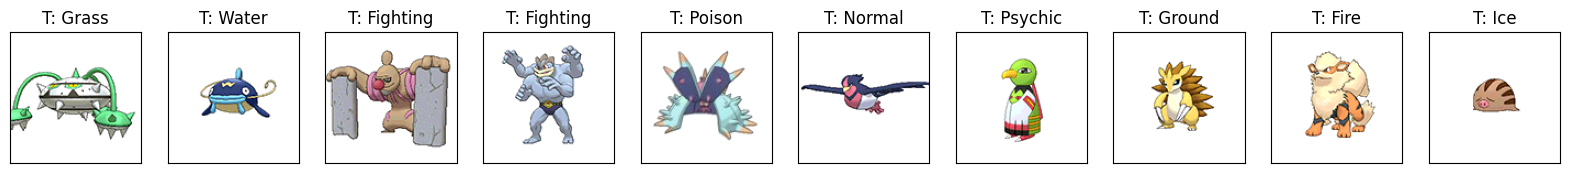

In [9]:
# Dataset
X, Y = generate_pokemon_dataset()

X = X / 255 # normalizing pixls

# 809 images of 120X120 pixels, each eencoded using 3 chanels 
print(X.shape, Y.shape)

show_images(X, Y, 10)

In [10]:
# train dataset
X_trn, Y_trn = X[:567, :, :, :], Y[:567]

# validation dataset
X_val, Y_val = X[567:, :, :, :], Y[567:]
 
X_trn.shape, X_val.shape

((567, 120, 120, 3), (242, 120, 120, 3))

In [11]:
pokemon_type_enc = OneHotEncoder()

Y_trn_oh = pokemon_type_enc.fit_transform(Y_trn.reshape(-1, 1)).toarray()
Y_val_oh = pokemon_type_enc.transform(Y_val.reshape(-1, 1)).toarray()

# no need fo tf.keras.utils.to_categorical(Y_trn, len(np.unique(Y_trn)))

Y_trn_oh = tf.convert_to_tensor(Y_trn_oh, dtype=tf.float32)
Y_val_oh = tf.convert_to_tensor(Y_val_oh, dtype=tf.float32)

Y_trn_oh.shape, Y_val_oh.shape

(TensorShape([567, 18]), TensorShape([242, 18]))

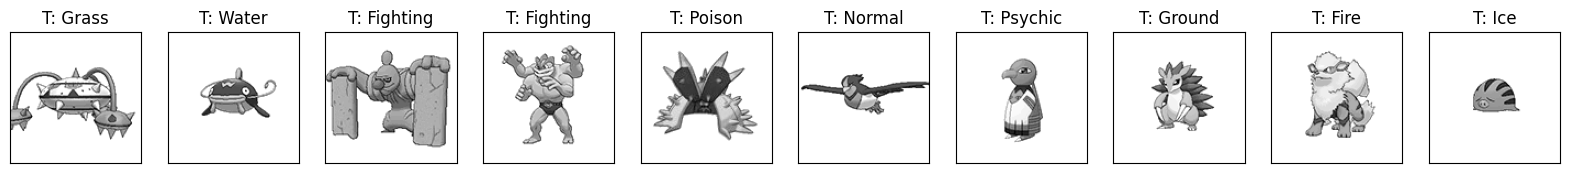

In [12]:
# TODO: pokemon grayscale
def greyscale(X, Y):
    return  np.dot(X, [1/3, 1/3, 1/3]), np.dot(Y, [1/3, 1/3, 1/3])

Xg_trn, Xg_val = greyscale(X_trn, X_val)
show_images(Xg_trn, Y_trn, 10)

### 1.3. Dogs dataset

Showing first 10 colored dog images (Training Set):


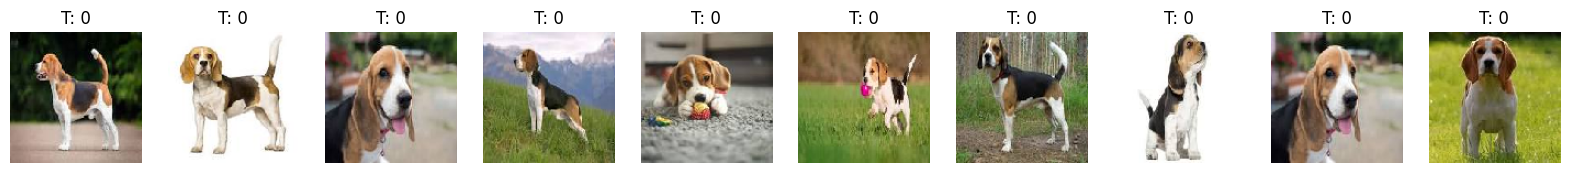

Showing first 10 grayscale dog images (Training Set):


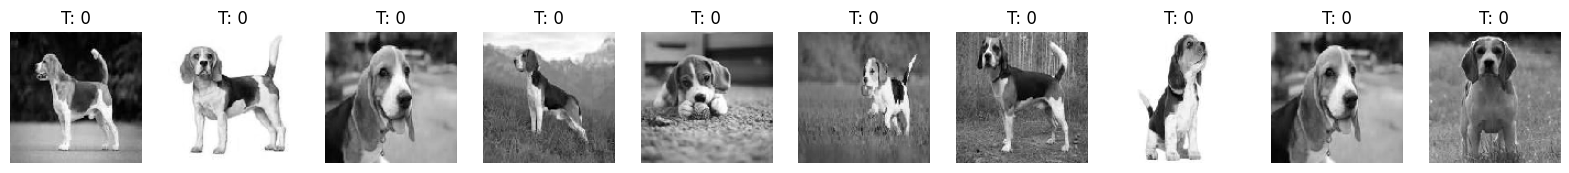

In [13]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # 

def rgb_to_grayscale(img):
    return np.mean(img, axis=-1, keepdims=True)  


DOGS_DATASET_PATH = 'data/dog/'  
classes = sorted(os.listdir(DOGS_DATASET_PATH))


X_dog_colored_trn, X_dog_colored_val = [], []
X_dog_gray_trn, X_dog_gray_val = [], []
Y_dog_trn, Y_dog_val = [], []

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DOGS_DATASET_PATH, class_name)
    images = sorted(os.listdir(class_path))

    
    for i, img_name in enumerate(images):  
        img_path = os.path.join(class_path, img_name)
        img = img_to_array(load_img(img_path, target_size=(120, 120))) / 255.0  

        
        img_gray = rgb_to_grayscale(img)

        if i < 70:
            X_dog_colored_trn.append(img)  
            X_dog_gray_trn.append(img_gray)  
            Y_dog_trn.append(class_idx)  
        else:
            X_dog_colored_val.append(img)  
            X_dog_gray_val.append(img_gray)  
            Y_dog_val.append(class_idx)  


X_dog_colored_trn, X_dog_colored_val = np.array(X_dog_colored_trn), np.array(X_dog_colored_val)
X_dog_gray_trn, X_dog_gray_val = np.array(X_dog_gray_trn), np.array(X_dog_gray_val)
Y_dog_trn, Y_dog_val = np.array(Y_dog_trn), np.array(Y_dog_val)


def show_images(imgs, y, n, cmap=None):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(imgs[i].squeeze(), cmap=cmap)
        plt.title(f"T: {y[i]}")
        ax.axis("off")
    plt.show()


print("Showing first 10 colored dog images (Training Set):")
show_images(X_dog_colored_trn, Y_dog_trn, 10)  

print("Showing first 10 grayscale dog images (Training Set):")
show_images(X_dog_gray_trn, Y_dog_trn, 10, cmap="gray")  

## 2. Images Classification

### 2.1. colored pokemons

In [ ]:
# TODO: colored pokemon model
from tensorflow.keras import layers, Sequential

colored_pokemons_model = keras.Sequential([
    Conv2D(32, (10, 10), activation='relu', strides=(1,1), input_shape=(120, 120, 3)),

    AvgPool2D((20, 20),strides=(20,20)),

    Flatten(),

    Dense(64, activation='relu'),

    layers.Dense(18, activation='softmax')
])
print(X_trn.shape, Y_trn_oh.shape)
colored_pokemons_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_colored_pokemons = colored_pokemons_model.fit(X_trn, Y_trn_oh, epochs=5, validation_data=(X_val, Y_val_oh))

test_loss, test_acc = colored_pokemons_model.evaluate(X_val, Y_val_oh, verbose=2)

print(f'\n Test ACC : {test_acc}')

c:\Users\thinkpad T14\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(567, 120, 120, 3) (567, 18)
Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.1051 - loss: 2.8637 - val_accuracy: 0.1322 - val_loss: 2.7612
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.1574 - loss: 2.7387 - val_accuracy: 0.1322 - val_loss: 2.7366
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.1331 - loss: 2.7693 - val_accuracy: 0.1322 - val_loss: 2.7117
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.1449 - loss: 2.7146 - val_accuracy: 0.1322 - val_loss: 2.6953
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.1512 - loss: 2.7093 - val_accuracy: 0.1322 - val_loss: 2.6944
8/8 - 0s - 41ms/step - accuracy: 0.1322 - loss: 2.6944

 Test ACC : 0.13223139941692352


### 2.2. grayscale pokemons

In [ ]:
# TODO: grayscale pokemon model
from tensorflow.keras import layers, Sequential

gray_pokemon_model = keras.Sequential([
    Conv2D(32, (10, 10), activation='relu', strides=(1,1), input_shape=(120, 120, 1)),

    AvgPool2D((20, 20),strides=(20,20)),

    Flatten(),

    Dense(64, activation='relu'),

    layers.Dense(18, activation='softmax')
])
print(Xg_trn.shape, Y_trn_oh.shape)
gray_pokemon_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_gray_pokemons = gray_pokemon_model.fit(Xg_trn, Y_trn_oh, epochs=5, validation_data=(Xg_val, Y_val_oh))

test_loss, test_acc = gray_pokemon_model.evaluate(Xg_val, Y_val_oh, verbose=2)

print(f'\n Test ACC : {test_acc}')

(567, 120, 120) (567, 18)
Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.0922 - loss: 2.8368 - val_accuracy: 0.1322 - val_loss: 2.7205
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.1484 - loss: 2.7374 - val_accuracy: 0.1446 - val_loss: 2.7025
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.1253 - loss: 2.7466 - val_accuracy: 0.1322 - val_loss: 2.7011
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.1510 - loss: 2.7126 - val_accuracy: 0.1488 - val_loss: 2.7107
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.1552 - loss: 2.7214 - val_accuracy: 0.1322 - val_loss: 2.6999
8/8 - 0s - 26ms/step - accuracy: 0.1322 - loss: 2.6999

 Test ACC : 0.13223139941692352


### 2.3. colored dogs

In [ ]:
# TODO: colored dogs model
from tensorflow.keras import layers, Sequential

colored_dogs_model = keras.Sequential([
    Conv2D(32, (10, 10), activation='relu', strides=(1,1), input_shape=(120, 120, 3)),

    AvgPool2D((20, 20),strides=(20,20)),

    Flatten(),

    Dense(64, activation='relu'),

    layers.Dense(18, activation='softmax')
])
print(X_dog_colored_trn.shape, Y_dog_trn.shape)

colored_dogs_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_colored_dogs = colored_dogs_model.fit(X_dog_colored_trn, Y_dog_trn, epochs=20,batch_size=32, validation_data=(X_dog_colored_val, Y_dog_val))

test_loss, test_acc = colored_dogs_model.evaluate(X_dog_colored_val, Y_dog_val, verbose=2)

print(f'\n Test ACC : {test_acc}')

(700, 120, 120, 3) (700,)
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.1299 - loss: 2.6464 - val_accuracy: 0.1760 - val_loss: 2.2522
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.2039 - loss: 2.2229 - val_accuracy: 0.1760 - val_loss: 2.1837
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.2237 - loss: 2.1206 - val_accuracy: 0.2622 - val_loss: 2.1330
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.2448 - loss: 2.0398 - val_accuracy: 0.2772 - val_loss: 2.0010
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.3234 - loss: 1.9536 - val_accuracy: 0.2734 - val_loss: 1.8886
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.3132 - loss: 1.8687 - val_accuracy: 0.3371 - val_loss: 1.8110
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.3367 - loss: 1.8228 - val_accuracy: 0.3221 - val_loss: 1.8194
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.3681 - loss:

### 2.4. grayscale dogs

In [ ]:
# TODO: grayscale dogs model
from tensorflow.keras import layers, Sequential

gray_dogs_model = keras.Sequential([
    Conv2D(32, (10, 10), activation='relu', strides=(1,1), input_shape=(120, 120, 1)),

    AvgPool2D((20, 20),strides=(20,20)),

    Flatten(),

    Dense(64, activation='relu'),

    layers.Dense(18, activation='softmax')
])
print(X_dog_gray_trn.shape, Y_dog_trn.shape)
gray_dogs_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_gray_dogs = gray_dogs_model.fit(X_dog_gray_trn, Y_dog_trn, epochs=20, validation_data=(X_dog_gray_val, Y_dog_val))

test_loss, test_acc = gray_dogs_model.evaluate(X_dog_gray_val, Y_dog_val, verbose=2)

print(f'\n Test ACC : {test_acc}')

(700, 120, 120, 1) (700,)
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.1036 - loss: 2.6724 - val_accuracy: 0.1798 - val_loss: 2.2526
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.1451 - loss: 2.2901 - val_accuracy: 0.2135 - val_loss: 2.1887
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.2150 - loss: 2.1549 - val_accuracy: 0.2472 - val_loss: 2.0911
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.2114 - loss: 2.1053 - val_accuracy: 0.2397 - val_loss: 2.1249
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2378 - loss: 2.0742 - val_accuracy: 0.2622 - val_loss: 2.0461
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.2660 - loss: 2.0186 - val_accuracy: 0.2884 - val_loss: 1.9509
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.3156 - loss: 1.9283 - val_accuracy: 0.2996 - val_loss: 1.9797
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.3253 - loss:

In [14]:
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
def plot_loss_evolution(history):
   
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_classification_report(model, X_val, Y_val_oh, problem_type):
    
    if problem_type != 'dogs':
        y_true = np.argmax(Y_val_oh, axis=1)
    else :
        y_true = Y_val_oh

    y_pred = np.argmax(model.predict(X_val), axis=1)

    report = classification_report(y_true, y_pred, output_dict=True)

    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Classification Report")
    plt.show()


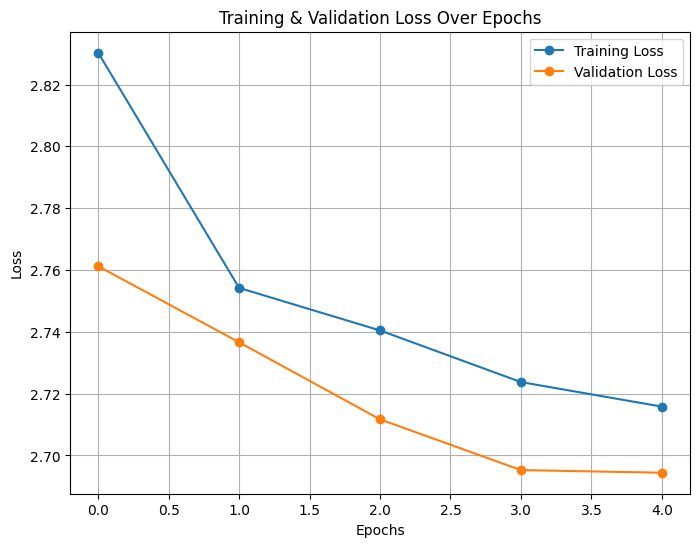

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


c:\Users\thinkpad T14\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thinkpad T14\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thinkpad T14\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

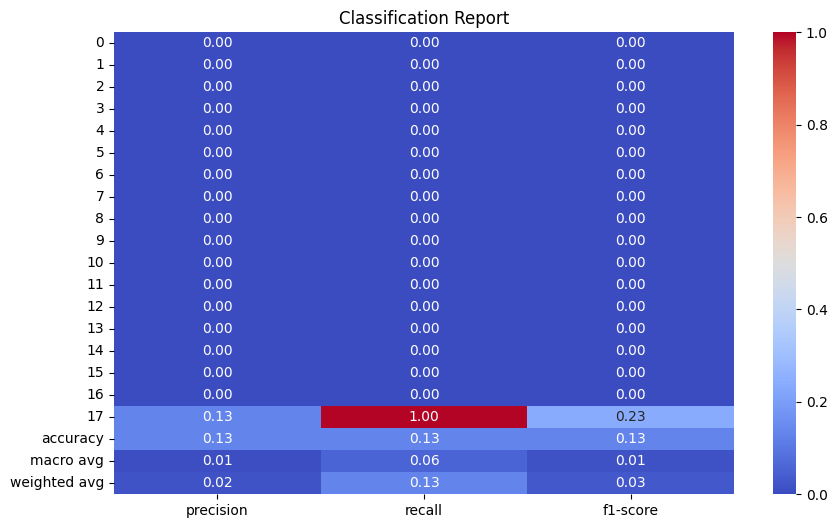

In [26]:
plot_loss_evolution(history_colored_pokemons)
plot_classification_report(colored_pokemons_model, X_val, Y_val_oh, 'pokemon')

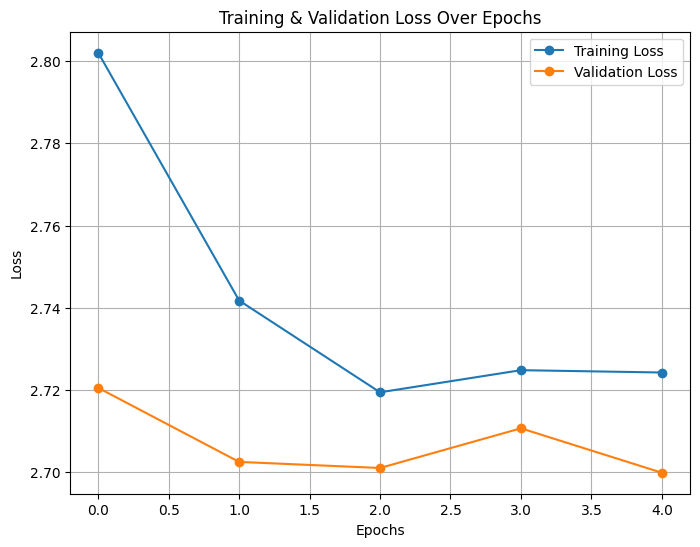

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


c:\Users\thinkpad T14\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thinkpad T14\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thinkpad T14\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

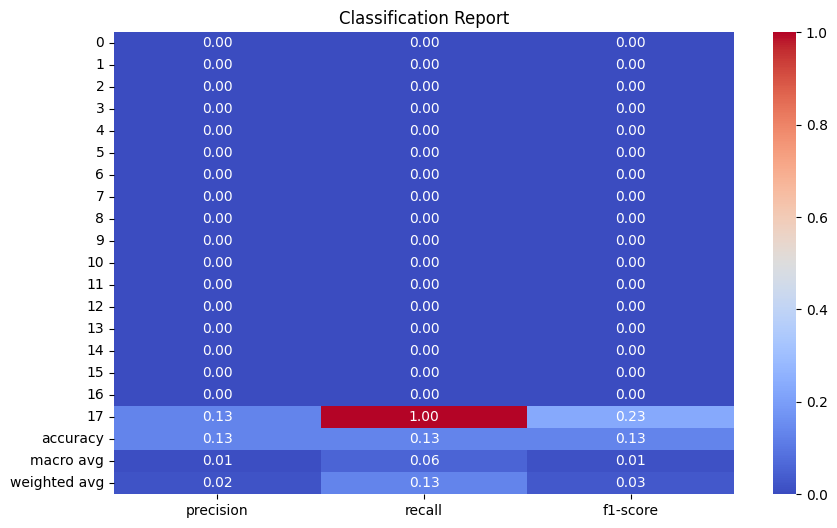

In [27]:
plot_loss_evolution(history_gray_pokemons)
plot_classification_report(gray_pokemon_model, Xg_val, Y_val_oh,'pokemon')

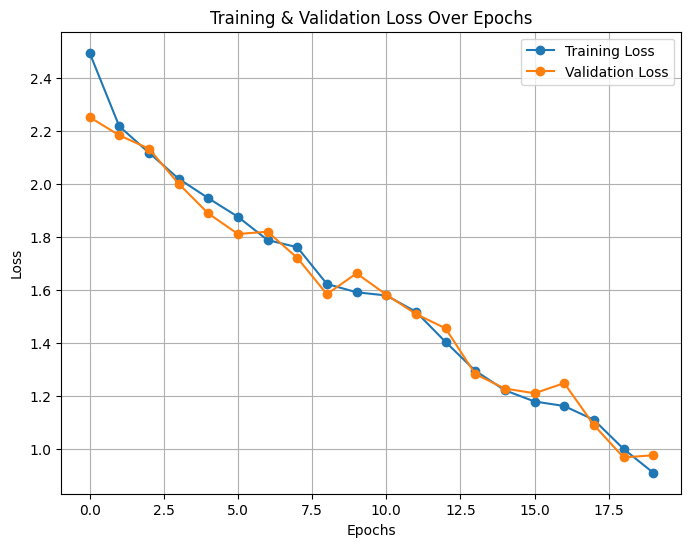

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


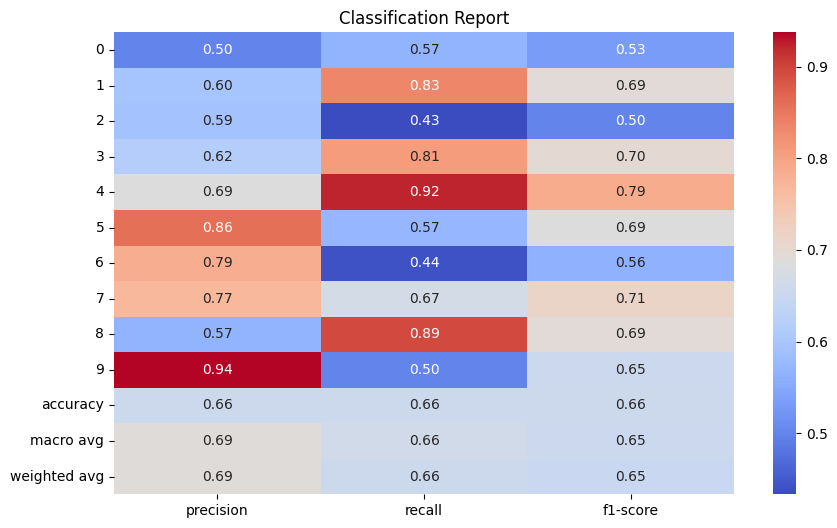

In [28]:
plot_loss_evolution(history_colored_dogs)
plot_classification_report(colored_dogs_model, X_dog_colored_val, Y_dog_val, 'dogs')

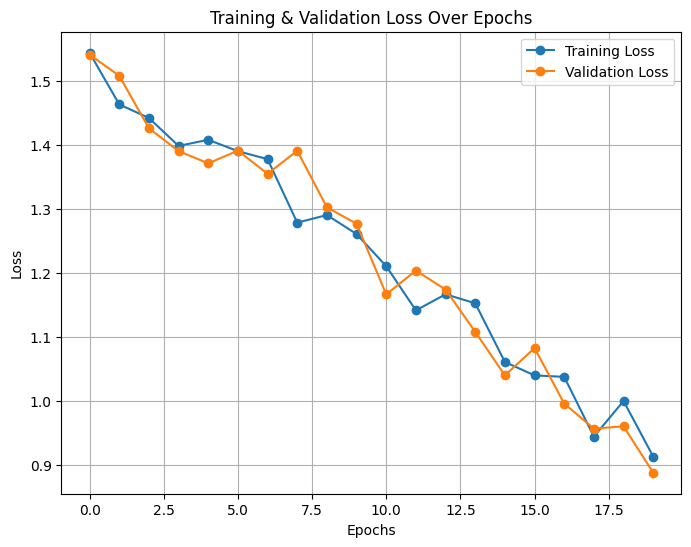

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


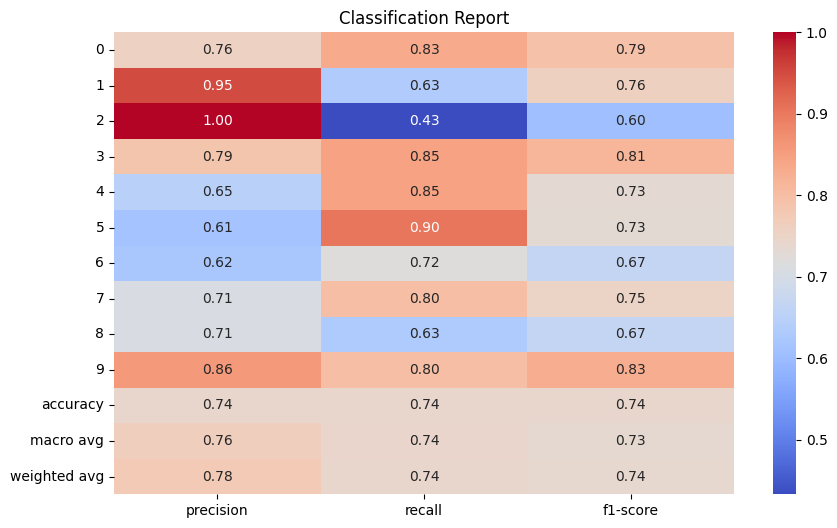

In [29]:
plot_loss_evolution(history_gray_dogs)
plot_classification_report(gray_dogs_model, X_dog_gray_val, Y_dog_val,'dogs')

## 3. Model Engineering

In [15]:
# TODO: Model Engineering
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Dense, Flatten, Dropout

def build_model(config):
    required_keys = ['input_shape', 'output_shape', 'output_activation', 'hidden_layers', 'mlp_units']

    if not isinstance(config, dict):
        raise TypeError("Config must be a dictionary.")

    missing_keys = [key for key in required_keys if key not in config]
    if missing_keys:
        raise ValueError(f"Missing required keys: {missing_keys}")

    try:
        inputs = Input(shape=config['input_shape'])
    except Exception as e:
        raise ValueError(f"Error creating input layer: {str(e)}")

    x = inputs

    for i, layer in enumerate(config['hidden_layers']):
        if 'type' not in layer:
            raise ValueError(f"Layer {i} is missing the 'type' key.")

        layer_type = layer['type']

        if layer_type == 'Conv2D':
            required_params = ['filters', 'kernel_size']
            missing_params = [p for p in required_params if p not in layer]
            if missing_params:
                raise ValueError(f"Conv2D layer {i} is missing parameters: {missing_params}")

            x = Conv2D(
                filters=layer['filters'],
                kernel_size=layer['kernel_size'],
                strides=layer.get('strides', (1, 1)),
                padding=layer.get('padding', 'valid'),
                activation=layer.get('activation', 'relu')
            )(x)

        elif layer_type == 'MaxPool2D':
            required_params = ['pool_size']
            if 'pool_size' not in layer:
                raise ValueError(f"MaxPool2D layer {i} is missing the 'pool_size' parameter.")

            x = MaxPooling2D(pool_size=layer['pool_size'])(x)

        elif layer_type == 'AvgPool2D':
            required_params = ['pool_size']
            if 'pool_size' not in layer:
                raise ValueError(f"AvgPool2D layer {i} is missing the 'pool_size' parameter.")

            x = AvgPool2D(pool_size=layer['pool_size'], strides=layer.get('strides', None))(x)

        elif layer_type == 'Dropout':
            required_params = ['dropout_rate']
            if 'dropout_rate' not in layer:
                raise ValueError(f"Dropout layer {i} is missing the 'dropout_rate' parameter.")

            x = Dropout(layer['dropout_rate'])(x)

        elif layer_type == 'Dense':
            required_params = ['units']
            if 'units' not in layer:
                raise ValueError(f"Dense layer {i} is missing the 'units' parameter.")

            x = Dense(
                units=layer['units'],
                activation=layer.get('activation', 'relu')
            )(x)

        else:
            raise ValueError(f"Unsupported layer type: {layer_type}")

    try:
        x = Flatten()(x)
    except Exception as e:
        raise ValueError(f"Error adding Flatten layer: {str(e)}")

    if not isinstance(config['mlp_units'], int):
        raise ValueError("MLP units must be an integer.")

    if config['mlp_units'] > 0:
        try:
            x = Dense(config['mlp_units'], activation='relu')(x)
        except Exception as e:
            raise ValueError(f"Error adding MLP layer: {str(e)}")

    try:
        outputs = Dense(config['output_shape'], activation=config['output_activation'])(x)
    except Exception as e:
        raise ValueError(f"Error adding output layer: {str(e)}")

    try:
        model = Model(inputs=inputs, outputs=outputs)
    except Exception as e:
        raise ValueError(f"Error constructing the model: {str(e)}")

    return model


## 4. Results enhancing

In [ ]:
# TODO: Results enhancing
# Enhace grayscale dogs model

dog_classes = len(np.unique(Y_dog_trn))

dogg_config = {
    'input_shape': (120, 120, 1),
    'hidden_layers': [
        {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'activation': 'relu', 'padding': 'valid'},
        {'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5), 'strides': (1, 1), 'activation': 'relu', 'padding': 'valid'},
        {'type': 'Dropout', 'dropout_rate': 0.25},
        {'type': 'MaxPool2D', 'pool_size': (21, 21), 'strides': (21, 21), 'padding': 'valid'},
        {'type': 'Dropout', 'dropout_rate': 0.25}
    ],
    'mlp_units': 256,
    'output_shape': dog_classes,
    'output_activation': 'softmax'
}

dogg_model = build_model(dogg_config)

dogg_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history_gray_dogs = dogg_model.fit(X_dog_gray_trn, Y_dog_trn, epochs=20,validation_data=(X_dog_gray_val, Y_dog_val))

test_loss, test_acc = dogg_model.evaluate(X_dog_gray_val, Y_dog_val, verbose=2)

print(f'\nTest Accuracy: {test_acc:.4f}')

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 625ms/step - accuracy: 0.0776 - loss: 2.3351 - val_accuracy: 0.1348 - val_loss: 2.2852
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 860ms/step - accuracy: 0.1835 - loss: 2.2501 - val_accuracy: 0.3333 - val_loss: 2.1504
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 753ms/step - accuracy: 0.3130 - loss: 2.0450 - val_accuracy: 0.4307 - val_loss: 1.8162
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 870ms/step - accuracy: 0.4118 - loss: 1.6815 - val_accuracy: 0.5543 - val_loss: 1.4676
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 856ms/step - accuracy: 0.5389 - loss: 1.3172 - val_accuracy: 0.5805 - val_loss: 1.2298
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 847ms/step - accuracy: 0.6536 - loss: 1.0732 - val_accuracy: 0.6217 - val_loss: 1.0499
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 760ms/step - accuracy: 0.6885 - loss: 0.9036 - val_accuracy: 0.8464 - val_loss: 0.6955
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 766ms/step - accuracy: 0.8545 - loss: 0.5348 - val_accu

In [33]:
# Enhace colored dogs model

dog_classes = len(np.unique(Y_dog_trn))

dogg_config = {
    'input_shape': (120, 120, 3),
    'hidden_layers': [
        {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'activation': 'relu', 'padding': 'valid'},
        {'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5), 'strides': (1, 1), 'activation': 'relu', 'padding': 'valid'},
        {'type': 'Dropout', 'dropout_rate': 0.25},
        {'type': 'MaxPool2D', 'pool_size': (21, 21), 'strides': (21, 21), 'padding': 'valid'},
        {'type': 'Dropout', 'dropout_rate': 0.25}
    ],
    'mlp_units': 256,
    'output_shape': dog_classes,
    'output_activation': 'softmax'
}

dogg_model = build_model(dogg_config)

dogg_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history_gray_dogs = dogg_model.fit(X_dog_colored_trn, Y_dog_trn, epochs=10,validation_data=(X_dog_colored_val, Y_dog_val))

test_loss, test_acc = dogg_model.evaluate(X_dog_colored_val, Y_dog_val, verbose=2)

print(f'\nTest Accuracy: {test_acc:.4f}')

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 631ms/step - accuracy: 0.1139 - loss: 2.3259 - val_accuracy: 0.2022 - val_loss: 2.2351
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 738ms/step - accuracy: 0.2587 - loss: 2.1516 - val_accuracy: 0.4082 - val_loss: 1.8689
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 658ms/step - accuracy: 0.4400 - loss: 1.6686 - val_accuracy: 0.6030 - val_loss: 1.3339
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 771ms/step - accuracy: 0.5562 - loss: 1.2340 - val_accuracy: 0.7303 - val_loss: 1.0176
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 829ms/step - accuracy: 0.7600 - loss: 0.8126 - val_accuracy: 0.8577 - val_loss: 0.6916
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 870ms/step - accuracy: 0.8530 - loss: 0.5033 - val_accuracy: 0.9663 - val_loss: 0.3456
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 815ms/step - accuracy: 0.9347 - loss: 0.2892 - val_accuracy: 0.9813 - val_loss: 0.2093
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 766ms/step - accuracy: 0.9534 - loss: 0.1906 - val_accu

In [25]:
# Enhance colored pokemon model

config = {
    'input_shape': (120, 120, 3),
    'output_shape': len(np.unique(Y_trn)),
    'output_activation': 'softmax',
    'hidden_layers': [
        {
            'type': 'Conv2D',
            'filters': 64,
            'kernel_size': (3, 3),
            'activation': 'relu',
            'padding': 'same'
        },
        {
            'type': 'MaxPool2D',
            'pool_size': (2, 2)
        },
        {
            'type': 'Dropout',
            'dropout_rate': 0.25
        },
        {
            'type': 'Conv2D',
            'filters': 128,
            'kernel_size': (3, 3),
            'activation': 'relu',
            'padding': 'same'
        },
        {
            'type': 'MaxPool2D',
            'pool_size': (2, 2)
        },
        {
            'type': 'Dropout',
            'dropout_rate': 0.25
        },
        {
            'type': 'Conv2D',
            'filters': 256,
            'kernel_size': (3, 3),
            'activation': 'relu',
            'padding': 'same'
        },
        {
            'type': 'MaxPool2D',
            'pool_size': (2, 2)
        },
        {
            'type': 'Dropout',
            'dropout_rate': 0.25
        },
    ],
    'mlp_units': 256,  # Increase MLP units
}
model = build_model(config)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)
history = model.fit(
    X_trn, Y_trn_oh,
    validation_data=(X_val, Y_val_oh),
    epochs=20,  
)
test_loss, test_acc = model.evaluate(X_val, Y_val_oh, verbose=2)

print(f'\nTest Accuracy: {test_acc:.4f}')


Epoch 1/20


2025-02-20 23:40:02.310648: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 117964800 exceeds 10% of free system memory.
2025-02-20 23:40:03.609765: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 117964800 exceeds 10% of free system memory.


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - accuracy: 0.1250 - loss: 2.8417

2025-02-20 23:40:03.930168: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 117964800 exceeds 10% of free system memory.
2025-02-20 23:40:05.169696: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 117964800 exceeds 10% of free system memory.


 2/18 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.1016 - loss: 9.6514 

2025-02-20 23:40:05.448385: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 117964800 exceeds 10% of free system memory.


18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.0812 - loss: 7.2775 - val_accuracy: 0.1322 - val_loss: 2.8297
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.1166 - loss: 2.7765 - val_accuracy: 0.1322 - val_loss: 2.7656
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.1621 - loss: 2.7088 - val_accuracy: 0.1033 - val_loss: 2.7674
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.1509 - loss: 2.7133 - val_accuracy: 0.1198 - val_loss: 2.7965
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.1195 - loss: 2.7083 - val_accuracy: 0.1322 - val_loss: 2.7506
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.1349 - loss: 2.6754 - val_accuracy: 0.1322 - val_loss: 2.7435
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1471 - loss: 2.6855 - val_accuracy: 0.1364 - val_loss: 2.7096
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.1924 - loss: 2.6513 - val_accuracy: 0.1901 - val_loss: 2.7173
Epo

In [ ]:

config = {
    'input_shape': (120, 120, 1), 
    'output_shape': 18,  
    'output_activation': 'softmax',  
    'hidden_layers': [
        {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'},
        {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'},
        {'type': 'MaxPool2D', 'pool_size': (2, 2)},
        {'type': 'Dropout', 'dropout_rate': 0.25},  

        {'type': 'Conv2D', 'filters': 128, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'},
        {'type': 'Conv2D', 'filters': 128, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'},
        {'type': 'MaxPool2D', 'pool_size': (2, 2)},
        {'type': 'Dropout', 'dropout_rate': 0.25},

        {'type': 'Conv2D', 'filters': 256, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'},
        {'type': 'Conv2D', 'filters': 256, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'},
        {'type': 'MaxPool2D', 'pool_size': (2, 2)},
        {'type': 'Dropout', 'dropout_rate': 0.25},

        {'type': 'Conv2D', 'filters': 512, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'},
        {'type': 'Conv2D', 'filters': 512, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'},
        {'type': 'MaxPool2D', 'pool_size': (2, 2)},
        {'type': 'Dropout', 'dropout_rate': 0.25},
    ],
    'mlp_units': 1024  # Fully connected dense layer before output
}
model = build_model(config)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)
history = model.fit(
    Xg_trn, Y_trn_oh,
    validation_data=(Xg_val, Y_val_oh),
    epochs=20,  
)
test_loss, test_acc = model.evaluate(Xg_val, Y_val_oh, verbose=2)

print(f'\nTest Accuracy: {test_acc:.4f}')


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.1206 - loss: 4.1769 - val_accuracy: 0.1446 - val_loss: 2.7743
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 99s 6s/step - accuracy: 0.1276 - loss: 2.7747 - val_accuracy: 0.1322 - val_loss: 2.7180
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 102s 6s/step - accuracy: 0.1501 - loss: 2.7235 - val_accuracy: 0.1322 - val_loss: 2.7059
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - accuracy: 0.1193 - loss: 2.7090 - val_accuracy: 0.1322 - val_loss: 2.6944
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.1398 - loss: 2.7239 - val_accuracy: 0.1322 - val_loss: 2.7155
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 125s 7s/step - accuracy: 0.1468 - loss: 2.6988 - val_accuracy: 0.1322 - val_loss: 2.7107
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.1609 - loss: 2.6865 - val_accuracy: 0.1322 - val_loss: 2.7176
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.1411 - loss: 2.7284 - val_accuracy: 0.1322 - va